In [1]:
#Import Plotting Libraries
import matplotlib.pyplot as plt
import seaborn as sns

#Importing Dependencies
import pandas as pd
import numpy as np
from numpy import nan

import csv
import nltk
import pickle

In [2]:
#Pre-Processing + Custom Class Integration
from sklearn.preprocessing import StandardScaler
from sklearn.base import TransformerMixin, BaseEstimator


#Model Imports
from sklearn.linear_model import LinearRegression, ElasticNetCV, RidgeCV, LassoCV
from sklearn.ensemble import RandomForestRegressor

#Model Boosting
from sklearn.ensemble import BaggingRegressor

#Model Metrics
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.metrics import mean_squared_error


#GridSearch
from sklearn.model_selection import GridSearchCV

#Scipy Integration for Sparse Matrixes
from scipy import sparse

#Additional Feature Engineering - NLP Text Data Import
from sklearn.feature_extraction.text import TfidfVectorizer

#PipeLine Imports
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline


#Multi-threaded Processing
from sklearn.externals import joblib

In [3]:
pd.set_option('display.max_columns', 500)

In [4]:
### Classes Custom Standard_Scaler  

class Standard_Scaler(BaseEstimator,TransformerMixin):
    
    def __init__(self, X, text_columns = None, numerical_columns= None):
        self.scaler = StandardScaler()
        self.text_columns = text_columns
        self.numerical_columns = numerical_columns
    
    def fit(self, X, *args):
        self.numerical_columns = X.select_dtypes(include= [np.number])
        self.text_columns = X[X.columns.difference(list(self.numerical_columns.columns))]
        self.scaler = self.scaler.fit(self.numerical_columns)
        return self
    
    
    def transform(self, X, *args):
        self.text_columns = X[X.columns.difference(list(self.numerical_columns.columns))]
        self.numerical_columns = X.select_dtypes(include= [np.number])
        # Fitting & Transforming The 
        numerical = pd.DataFrame(self.scaler.transform(self.numerical_columns), columns = X.columns.difference(['Article_Text']),
                                index = self.numerical_columns.index)
        
        # Horizontally Stacking The Scaled Numerical Data With The Text Data
        X = pd.concat([numerical, self.text_columns], axis=1, sort=True)
        
        return X

In [5]:
class TFID_Vectorizer(BaseEstimator,TransformerMixin):
    
    def __init__(self, X, ngram_range = None, min_df = None, max_df = None, 
                 max_features= None):
        self.ngram_range = ngram_range
        self.min_df = min_df
        self.max_df = max_df
        self.max_features = max_features
        self.tvec = TfidfVectorizer(stop_words='english', ngram_range = self.ngram_range, min_df= self.min_df, 
                                    max_df = self.max_df, max_features = self.max_features)
    
    def fit(self, X, *args):
        self.text_columns = X.select_dtypes('object')['Article_Text']
        self.tvec = self.tvec.fit(self.text_columns)
        return self
    
    
    def transform(self, X, *args):
        self.text_columns = X.select_dtypes('object')['Article_Text']
        self.numerical_columns = X[X.columns.difference(['Article_Text'])]
        
        X = self.tvec.transform(self.text_columns)
        self.sparse_numerical_data = sparse.csr_matrix(self.numerical_columns)
        
        #Concatenating The Sparse Matrices Together
        X = sparse.hstack([X, self.sparse_numerical_data])
        
        return X

In [6]:
cleaned_df = pd.read_pickle('Ignore/cleaned_data.pkl')
cleaned_df.dropna(axis= 0, inplace = True)

In [7]:
X = cleaned_df
y = cleaned_df.pop('Total_Shares')
cleaned_df.drop(axis=1, columns = ['Url', 'Published_Date', 'Setences_Text', 'Meta_Description', 'Title_Text' ], inplace=True)

In [8]:
New_Scaler = Standard_Scaler(cleaned_df)
TFID = TFID_Vectorizer(cleaned_df, (1,4), 0.01, 0.5, None)

##  Models To Test

In [ ]:
Linear_Regression = LinearRegression()
RFR = RandomForestRegressor(n_estimators=100)
Ridge = RidgeCV(alphas=(0.0001, 0.001, 0.01, 0.1, 1.0 ), cv = 5)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=3)
X_train.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)

------------------------------------------------------------------------------------------------------------------------------------------------

## 1. Testing That The TVEC + StandardScaler Give The Same Scores As The Manual Approach (To Do)

In [9]:
cleaned_df = pd.read_pickle('Ignore/cleaned_data.pkl')
numerical_columns = cleaned_df.select_dtypes(np.number)
text_columns = cleaned_df.select_dtypes('object')
cleaned_df.drop(axis=1, columns = ['Url', 'Published_Date', 'Setences_Text'], inplace=True)
cleaned_df.dropna(axis= 0, inplace = True)

In [10]:
#1 Initialize The Scaler
scaler = StandardScaler()
X = cleaned_df
y = cleaned_df.pop('Total_Shares')

In [11]:
#2 Setup A Train Test Split
X_train, X_test, y_train, y_test = train_test_split(
X, y, test_size = 0.2, random_state= 1)

In [57]:
#3 Performing TFID Vectorizing Upon The Text Data
vectorizer = TfidfVectorizer(stop_words = 'english'
                            ,min_df=3, 
                             ngram_range=(1, 4),
                             max_features = 1000,
                            )

#Ensuring That All Of The Rows Are String Type
# X_train['Article_Text'] = X_train['Article_Text'].astype(str)
# X_test['Article_Text'] = X_test['Article_Text'].astype(str)

In [58]:
X2_train_titles = pickle.load(open('X2_train_titles.pkl', 'rb'))
X2_test_titles = pickle.load(open('X2_test_titles.pkl','rb'))

In [59]:
# Drop The Additional Text Columns - Potentially Revert This :)
X_train.drop(axis=1, columns = ['Article_Text', 'Meta_Description', 'Title_Text'], inplace= True)
X_test.drop(axis=1, columns = ['Article_Text', 'Meta_Description', 'Title_Text'], inplace= True)

/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [60]:
X_train.shape

(12770, 60)

In [61]:
X_test.shape

(3193, 60)

In [62]:
test_one = pd.DataFrame(X2_train_titles.toarray())
test_two = pd.DataFrame(X2_test_titles.toarray())

In [63]:
test_one.shape

(12770, 1000)

In [64]:
test_two.shape

(3193, 1000)

In [65]:
#Merge The Text Data With The DataFrame Matrix

In [66]:
X_train.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)

In [67]:
X_train = pd.concat([X_train, test_one], axis=1)
X_test = pd.concat([X_test, test_two], axis=1)

In [68]:
X_train.shape

(12770, 1060)

In [69]:
X_test.shape

(3193, 1060)

In [70]:
#4 Apply Standardized Scaling To The Original Matrix.
X_train_std = scaler.fit_transform(X_train)
X_test_std = scaler.transform(X_test)

/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.7/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  This is separate from the ipykernel package so we can avoid doing imports until


In [75]:
y_train.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)

In [76]:
Lasso_Test = LassoCV(n_alphas=100)

In [ ]:
Lasso_Test.fit(X_train)
Lasso_Test.score(X_train)
Lasso_Test.score(X_test)

### Testing The Pipeline Vs The Manual Approach Above 

In [78]:
X_train

,Evergreen_Score,Word_Count,num_linking_domains,Article_Text_Length,Has_Top_Image,Number_of_Movies,Article_Is_Media_News,Number_Of_Images,Is_Valid_Body,Number_Of_Sentences,Lexicon_Count,Flesch_Reading_Ease_formula,Flesch_Kincaid_Grade_Level,FOG_Scale,SMOG_Index,ARI_Index,Title_Tag_Length,Meta_Description_Length,SSL,Page_Size_In_Bytes,Plain_Text_Size,Plain_Text_Rate,Has_Referring_Domains,Has_Article_Amplifiers,Has_Author_Name,Topic_Content Marketing,Topic_Copywriting,Topic_Display Advertising,Topic_Email Marketing,Topic_Growth Marketing,Topic_Influencer Marketing,Topic_Link Building,Topic_Marketing Automation,Topic_Podcast Marketing,Topic_Search Engine Marketing,Topic_Social Media Marketing,Topic_Video Marketing,Topic_Website Design,Encoding_ISO-8859-1,Encoding_UTF-8,Encoding_iso-8859-1,Encoding_utf-8,Encoding_windows-1252,Number_Of_Article_Amplifiers,"article_types_['how_to_article', 'general_article']","article_types_['how_to_article', 'infographic', 'general_article']","article_types_['how_to_article', 'list', 'general_article']","article_types_['how_to_article', 'newsletter', 'general_article']","article_types_['how_to_article', 'what_post', 'general_article']","article_types_['how_to_article', 'why_post', 'general_article']","article_types_['infographic', 'general_article']","article_types_['list', 'general_article']","article_types_['list', 'infographic', 'general_article']","article_types_['list', 'newsletter', 'general_article']","article_types_['newsletter', 'general_article']","article_types_['what_post', 'general_article']","article_types_['what_post', 'infographic', 'general_article']","article_types_['what_post', 'newsletter', 'general_article']","article_types_['why_post', 'general_article']","article_types_['why_post', 'newsletter', 'general_article']",0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,...,750,751,752,753,754,755,756,757,758,759,760,761,762,763,764,765,766,767,768,769,770,771,772,773,774,775,776,777,778,779,780,781,782,783,784,785,786,787,788,789,790,791,792,793,794,795,796,797,798,799,800,801,802,803,804,805,806,807,808,809,810,811,812,813,814,815,816,817,818,819,820,821,822,823,824,825,826,827,828,829,830,831,832,833,834,835,836,837,838,839,840,841,842,843,844,845,846,847,848,849,850,851,852,853,854,855,856,857,858,859,860,861,862,863,864,865,866,867,868,869,870,871,872,873,874,875,876,877,878,879,880,881,882,883,884,885,886,887,888,889,890,891,892,893,894,895,896,897,898,899,900,901,902,903,904,905,906,907,908,909,910,911,912,913,914,915,916,917,918,919,920,921,922,923,924,925,926,927,928,929,930,931,932,933,934,935,936,937,938,939,940,941,942,943,944,945,946,947,948,949,950,951,952,953,954,955,956,957,958,959,960,961,962,963,964,965,966,967,968,969,970,971,972,973,974,975,976,977,978,979,980,981,982,983,984,985,986,987,988,989,990,991,992,993,994,995,996,997,998,999
0,0.82,1438,1.0,10067,1,0,0,13,1,77,1566,42.04,14.6,14.97,15.9,18.7,77,19,1,106712,10067,9.433803,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.023145,0.018345,0.021465,0.000000,0.000000,0.0,0.022911,0.019945,0.027130,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.025417,0.000000,0.041778,0.000000,0.000000,0.000000,0.000000,0.0

In [79]:
New_Scaler = Standard_Scaler(cleaned_df)
TFID = TFID_Vectorizer(cleaned_df, (0,4), 3, None, 1000)
cleaned_df = pd.read_pickle('Ignore/cleaned_data.pkl')
cleaned_df.dropna(axis= 0, inplace = True)
X = cleaned_df
y = cleaned_df.pop('Total_Shares')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=3)

In [ ]:
pipe_lasso = Pipeline([('sc1', New_Scaler),
                    ('TFID_vec', TFID ),
                   ('Model', LassoCV(n_alphas=100))])

pipe_lasso.fit(X_train)
pipe_lasso.score(X_train)

In [ ]:
pipe_lasso.score(X_test)

------------------------------------------------------------------------------------------------------------------------------------------------

## 2.  Testing The Data In A Simple Pipeline With Regularization (Needs Debugging)

In [77]:
cleaned_df

,Evergreen_Score,Word_Count,num_linking_domains,Article_Text,Article_Text_Length,Has_Top_Image,Number_of_Movies,Article_Is_Media_News,Number_Of_Images,Is_Valid_Body,Number_Of_Sentences,Lexicon_Count,Flesch_Reading_Ease_formula,Flesch_Kincaid_Grade_Level,FOG_Scale,SMOG_Index,ARI_Index,Title_Text,Title_Tag_Length,Meta_Description,Meta_Description_Length,SSL,Page_Size_In_Bytes,Plain_Text_Size,Plain_Text_Rate,Has_Referring_Domains,Has_Article_Amplifiers,Has_Author_Name,Topic_Content Marketing,Topic_Copywriting,Topic_Display Advertising,Topic_Email Marketing,Topic_Growth Marketing,Topic_Influencer Marketing,Topic_Link Building,Topic_Marketing Automation,Topic_Podcast Marketing,Topic_Search Engine Marketing,Topic_Social Media Marketing,Topic_Video Marketing,Topic_Website Design,Encoding_ISO-8859-1,Encoding_UTF-8,Encoding_iso-8859-1,Encoding_utf-8,Encoding_windows-1252,Number_Of_Article_Amplifiers,"article_types_['how_to_article', 'general_article']","article_types_['how_to_article', 'infographic', 'general_article']","article_types_['how_to_article', 'list', 'general_article']","article_types_['how_to_article', 'newsletter', 'general_article']","article_types_['how_to_article', 'what_post', 'general_article']","article_types_['how_to_article', 'why_post', 'general_article']","article_types_['infographic', 'general_article']","article_types_['list', 'general_article']","article_types_['list', 'infographic', 'general_article']","article_types_['list', 'newsletter', 'general_article']","article_types_['newsletter', 'general_article']","article_types_['what_post', 'general_article']","article_types_['what_post', 'infographic', 'general_article']","article_types_['what_post', 'newsletter', 'general_article']","article_types_['why_post', 'general_article']","article_types_['why_post', 'newsletter', 'general_article']"
0,1.54,4767,1.0,"Some of the links below are affiliate links, s...",27301,1,0,0,42,1,261,4810,46.98,16.8,17.43,15.1,21.2,Affiliate Marketing for Dummies: A Smart Guide...,79,A step-by-step affiliate marketing for dummies...,151,1,186434,27301,14.643788,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1.44,1181,2.0,Would you like to make money while you sleep?\...,6519,1,0,0,24,1,65,1154,53.99,14.2,15.29,13.2,17.6,HOW TO USE AFFILIATE MARKETING TO MAKE MONEY B...,69,Do you want to make money while you sleep? Her...,150,1,96481,6519,6.756771,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,5.68,996,12.0,Learn three simple strategies to help you stac...,5916,1,0,0,12,1,65,1001,46.03,15.1,16.04,14.5,18.6,How to Build a Profitable Business Online by S...,60,Learn three simple strategies to help you stac...,122,1,85973,5916,6.881230,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1.30,8996,3.0,I never thought this would happen to me.\n\nIn...,39589,1,0,0,113,1,353,6529,50.70,13.3,13.01,13.5,17.0,How To Make Money With Affiliate Marketing In ...,63,I made $150k last year in affiliate marketing ...,114,1,421899,39589,9.383525,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1.53,2226,1.0,This post may contain affiliate links. Please ...,12657,1,0,0,28,1,140,2227,59.06,12.2,12.84,13.1,15.2,How To Make Money With Affiliate Marketing For...,73,No Meta_Description,19,1,149458,12657,8.468600,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,0.18,1489,0.0,Affiliate marketing is one of the easiest ways...,9050,1,0,0,10,1,82,1481,44.11,15.9,16.42,14.7,20.5,The 5 BEST Affiliate Marketing Networks for Ne...,72,Affiliate marketing networks offer bloggers ac...,159,1,80949,9050,11.179879,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6,2.05,698,0.0,Making a full-time income with affiliate marke...,4741,1,0,0,10,1,48,811,62.72,10.8,12.83,13.0,14.2,8 Creative Ways to Monetize a Blog with Affili...,59,No Meta_Description,19,1,72053,4741,6.579879,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0

In [58]:
sdf = pd.SparseDataFrame(TFID.fit_transform(X_train))

In [59]:
sdf.shape

(12594, 813)

In [60]:
sdf_two = pd.SparseDataFrame(TFID.transform(X_test))
sdf_two.shape

(3149, 813)

In [61]:
X_train.head(2)

,Evergreen_Score,Word_Count,num_linking_domains,Article_Text,Article_Text_Length,Has_Top_Image,Number_of_Movies,Article_Is_Media_News,Number_Of_Images,Is_Valid_Body,Number_Of_Sentences,Lexicon_Count,Flesch_Reading_Ease_formula,Flesch_Kincaid_Grade_Level,FOG_Scale,SMOG_Index,ARI_Index,Title_Tag_Length,Meta_Description_Length,SSL,Page_Size_In_Bytes,Plain_Text_Size,Plain_Text_Rate,Has_Referring_Domains,Has_Article_Amplifiers,Has_Author_Name,Topic_Content Marketing,Topic_Copywriting,Topic_Display Advertising,Topic_Email Marketing,Topic_Growth Marketing,Topic_Influencer Marketing,Topic_Link Building,Topic_Marketing Automation,Topic_Podcast Marketing,Topic_Search Engine Marketing,Topic_Social Media Marketing,Topic_Video Marketing,Topic_Website Design,Encoding_ISO-8859-1,Encoding_UTF-8,Encoding_iso-8859-1,Encoding_utf-8,Encoding_windows-1252,Number_Of_Article_Amplifiers,"article_types_['how_to_article', 'general_article']","article_types_['how_to_article', 'infographic', 'general_article']","article_types_['how_to_article', 'list', 'general_article']","article_types_['how_to_article', 'newsletter', 'general_article']","article_types_['how_to_article', 'what_post', 'general_article']","article_types_['how_to_article', 'why_post', 'general_article']","article_types_['infographic', 'general_article']","article_types_['list', 'general_article']","article_types_['list', 'infographic', 'general_article']","article_types_['list', 'newsletter', 'general_article']","article_types_['newsletter', 'general_article']","article_types_['what_post', 'general_article']","article_types_['what_post', 'infographic', 'general_article']","article_types_['what_post', 'newsletter', 'general_article']","article_types_['why_post', 'general_article']","article_types_['why_post', 'newsletter', 'general_article']"
2506,0.00,280,0.0,Having a thorough content strategy plays a vit...,1476,1,0,0,2,0,12,243,49.08,14.0,15.78,14.4,17.8,41,118,1,35498,1476,4.157981,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2311,0.36,1966,1.0,Recently google found that one in every 20 sea...,12467,1,0,0,15,1,97,2176,28.71,23.9,25.54,18.2,30.4,55,176,1,157072,12467,7.937124,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [62]:
X_test.head(2)

,Evergreen_Score,Word_Count,num_linking_domains,Article_Text,Article_Text_Length,Has_Top_Image,Number_of_Movies,Article_Is_Media_News,Number_Of_Images,Is_Valid_Body,Number_Of_Sentences,Lexicon_Count,Flesch_Reading_Ease_formula,Flesch_Kincaid_Grade_Level,FOG_Scale,SMOG_Index,ARI_Index,Title_Tag_Length,Meta_Description_Length,SSL,Page_Size_In_Bytes,Plain_Text_Size,Plain_Text_Rate,Has_Referring_Domains,Has_Article_Amplifiers,Has_Author_Name,Topic_Content Marketing,Topic_Copywriting,Topic_Display Advertising,Topic_Email Marketing,Topic_Growth Marketing,Topic_Influencer Marketing,Topic_Link Building,Topic_Marketing Automation,Topic_Podcast Marketing,Topic_Search Engine Marketing,Topic_Social Media Marketing,Topic_Video Marketing,Topic_Website Design,Encoding_ISO-8859-1,Encoding_UTF-8,Encoding_iso-8859-1,Encoding_utf-8,Encoding_windows-1252,Number_Of_Article_Amplifiers,"article_types_['how_to_article', 'general_article']","article_types_['how_to_article', 'infographic', 'general_article']","article_types_['how_to_article', 'list', 'general_article']","article_types_['how_to_article', 'newsletter', 'general_article']","article_types_['how_to_article', 'what_post', 'general_article']","article_types_['how_to_article', 'why_post', 'general_article']","article_types_['infographic', 'general_article']","article_types_['list', 'general_article']","article_types_['list', 'infographic', 'general_article']","article_types_['list', 'newsletter', 'general_article']","article_types_['newsletter', 'general_article']","article_types_['what_post', 'general_article']","article_types_['what_post', 'infographic', 'general_article']","article_types_['what_post', 'newsletter', 'general_article']","article_types_['why_post', 'general_article']","article_types_['why_post', 'newsletter', 'general_article']"
6422,0.0,127,0.0,http://amzn.to/2pFBR3F If you feel utterly los...,814,1,0,0,44,0,5,144,59.16,12.2,13.74,11.6,14.9,131,816,1,254738,814,0.319544,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8758,0.0,1016,0.0,Influencer marketing is one of the most profit...,6171,1,0,0,4,1,69,1007,53.75,12.2,12.43,15.0,15.8,56,162,1,59072,6171,10.446574,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [63]:
y_train.head(2)

2506    4
2311    5
Name: Total_Shares, dtype: int64

In [64]:
y_test.head(2)

6422    0
8758    0
Name: Total_Shares, dtype: int64

-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [65]:
TFID = TFID_Vectorizer(cleaned_df, (0,2), 0.05, 0.5, None)
ridge_alphas = np.logspace(0, 5 , 200)
Ridge = RidgeCV(alphas= ridge_alphas)

pipe_ridge = Pipeline([('sc1', New_Scaler),
                    ('TFID_vec', TFID),
                   ('Model', Ridge)])

In [66]:
pipe_ridge.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('sc1',
                 Standard_Scaler(X=None,
                                 numerical_columns=       Evergreen_Score  Word_Count  num_linking_domains  Article_Text_Length  \
2506              0.00         280                  0.0                 1476   
2311              0.36        1966                  1.0                12467   
4936              0.32        1490                  1.0                 8405   
4457              0.00         613                  0.0                 3678   
14392             0.00         115                  0.0                  614   
14350             0.19         803                  0.0                 4630   
161               0.56         962                  0.0                 5751   
689               0.73         303                  0.0                 1861   
11275             0.37        1438                  0.0                 8578   
12117             0.18        1053                  0.0       

In [67]:
pipe_ridge.score(X_train, y_train)

0.0004030606358621514

In [68]:
pipe_ridge.score(X_test, y_test)

-0.0005788176386554156

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

## Non-logged Data Lasso - Complete

In [72]:
TFID = TFID_Vectorizer(cleaned_df, (0,2), 0.05, 0.5, None)

pipe_ridge = Pipeline([('sc1', StandardScaler()),
                   ('Model', LassoCV(alphas = np.linspace(0.01, 10, 50), n_jobs=-1))])

In [73]:
pipe_ridge.fit(X_train.select_dtypes(['int','float']), y_train)

C:\Users\james.DESKTOP-36N7TSQ\AppData\Roaming\Python\Python37\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\james.DESKTOP-36N7TSQ\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 69823055.55365872, tolerance: 110530.4617081944
  tol, rng, random, positive)
C:\Users\james.DESKTOP-36N7TSQ\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8912375.187268972, tolerance: 82202.66527750122
  tol, rng, random, positive)
C:\Users\james.DESKTOP-36N7TSQ\AppData\Roaming\Python\Python37\site-packages\sk

Pipeline(memory=None,
         steps=[('sc1',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('Model',
                 LassoCV(alphas=array([ 0.01      ,  0.21387755,  0.4177551 ,  0.62163265,  0.8255102 ,
        1.02938776,  1.23326531,  1.43714286,  1.64102041,  1.84489796,
        2.04877551,  2.25265306,  2.45653061,  2.66040816,  2.86428571,
        3.06816327,  3.27204082,  3.47591837,  3.67979592,  3.88367347,
        4.08755102,  4.291...
        7.14571429,  7.34959184,  7.55346939,  7.75734694,  7.96122449,
        8.16510204,  8.36897959,  8.57285714,  8.77673469,  8.98061224,
        9.1844898 ,  9.38836735,  9.5922449 ,  9.79612245, 10.        ]),
                         copy_X=True, cv='warn', eps=0.001, fit_intercept=True,
                         max_iter=1000, n_alphas=100, n_jobs=-1,
                         normalize=False, positive=False, precompute='auto',
                         random_state=None, selection='cyclic'

In [74]:
pipe_ridge.score(X_train.select_dtypes(['int','float']), y_train)

0.4040412072187083

In [75]:
pipe_ridge.score(X_test.select_dtypes(['int','float']), y_test)

0.14494142579450875

------------------------------------------------------------------------------------------------------------------------------------------------------

## Log The Target Variable - Complete

In [77]:
cleaned_df = pd.read_pickle('Ignore/cleaned_data.pkl')
cleaned_df.dropna(axis= 0, inplace = True)

In [78]:
cleaned_df['Total_Shares'] = cleaned_df['Total_Shares'].apply(lambda x: np.log1p(x))

In [79]:
X = cleaned_df
y = cleaned_df.pop('Total_Shares')

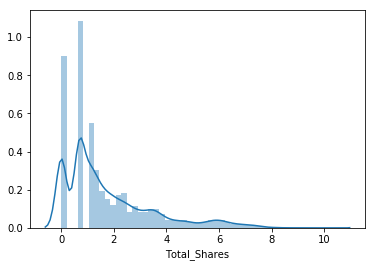

In [80]:
sns.distplot(y)
plt.show()

In [81]:
cleaned_df.drop(axis=1, columns = ['Url', 'Published_Date', 'Setences_Text', 'Meta_Description', 'Title_Text' ], inplace=True)

## 1. Log Data - Lasso - Complete

In [83]:
TFID = TFID_Vectorizer(cleaned_df, (0,2), 0.05, 0.5, None)

pipe_ridge_log = Pipeline([('sc1', StandardScaler()),
                   ('Model', LassoCV(alphas = np.linspace(0.01, 10, 50), n_jobs=-1))])

In [84]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 3)

In [85]:
pipe_ridge_log.fit(X_train.select_dtypes(['int','float']), y_train)
pipe_ridge_log.score(X_train.select_dtypes(['int','float']), y_train)

C:\Users\james.DESKTOP-36N7TSQ\AppData\Roaming\Python\Python37\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


0.46197752567258116

In [86]:
pipe_ridge_log.score(X_test.select_dtypes(['int','float']), y_test)

0.45811482772412243

------------------------------------------------------------------------------------------------------------------------------------------------------

## 2. Log Numerical Data - Random Forest

In [3]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor
cleaned_df = pd.read_pickle('Ignore/cleaned_data.pkl')
cleaned_df.dropna(axis= 0, inplace = True)
cleaned_df['Total_Shares'] = cleaned_df['Total_Shares'].apply(lambda x: np.log1p(x))

In [4]:
X = cleaned_df
y = cleaned_df.pop('Total_Shares')

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 3)

In [6]:
X_train

,Url,Evergreen_Score,Published_Date,Word_Count,num_linking_domains,Article_Text,Article_Text_Length,Has_Top_Image,Number_of_Movies,Article_Is_Media_News,...,"article_types_['infographic', 'general_article']","article_types_['list', 'general_article']","article_types_['list', 'infographic', 'general_article']","article_types_['list', 'newsletter', 'general_article']","article_types_['newsletter', 'general_article']","article_types_['what_post', 'general_article']","article_types_['what_post', 'infographic', 'general_article']","article_types_['what_post', 'newsletter', 'general_article']","article_types_['why_post', 'general_article']","article_types_['why_post', 'newsletter', 'general_article']"
2506,http://www.wordsmith.com.pk/why-your-company-n...,0.00,2018-09-27,280,0.0,Having a thorough content strategy plays a vit...,1476,1,0,0,...,0,0,0,0,0,0,0,0,1,0
2311,https://poofnewsales.com/healthcare-content-ma...,0.36,2018-08-16,1966,1.0,Recently google found that one in every 20 sea...,12467,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4936,https://www.rivmedia.co.uk/the-ultimate-guide-...,0.32,2018-08-23,1490,1.0,Email marketing campaigns are tough campaigns ...,8405,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4457,https://www.josephstudios.net/how-seo-copywrit...,0.00,2018-09-10,613,0.0,How SEO Copywriting Helps Businesses Rank Bett...,3678,1,0,0,...,0,0,0,0,0,0,0,0,0,0
14392,https://www.katesreviews.com/2018/09/30/free-g...,0.00,2018-09-30,115,0.0,Video Marketing is the Best Free Form of Onlin...,614,1,0,0,...,0,0,0,0,0,0,0,0,0,0
14350,https://info.madisontaylormarketing.com/blog/6...,0.19,2018-09-19,803,0.0,Video content is everywhere these days. The nu...,4630,1,0,0,...,0,1,0,0,0,0,0,0,0,0
161,https://dailynewshungary.com/whats-the-best-am...,0.56,2018-09-26,962,0.0,If you want to make positive changes to your c...,5751,1,0,0,...,0,0,0,0,0,0,0,0,0,0
689,https://www.leasedadspace.com/members/garrytat...,0.73,2018-08-21,303,0.0,There is no better time to start. This article...,1861,1,0,0,...,0,0,0,0,0,0,0,0,0,0
11275,https://www.quavzent.com/content-marketing/sea...,0.37,2018-09-05,1438,0.0,If you’re running a website for a long time th...,8578,1,0,0,...,0,1,0,0,0,0,0,0,0,0
12117,https://www.area19delegate.org/social-media-ma...,0.18,2018-08-30,1053,0.0,"Social media marketing can be overwhelming, es...",5704,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [7]:
cleaned_df.drop(axis=1, columns = ['Url', 'Published_Date', 'Setences_Text', 'Meta_Description', 'Title_Text' ], inplace=True)

In [8]:
def do_cross_val(model, X, y, cv=5):
    scores = cross_val_score(model, X, y, cv=cv, n_jobs=1,
                             scoring='neg_mean_squared_error')
    # , scores.std()#, cross_val_score(model, X, y, cv=cv, n_jobs=1).mean()
    return scores.mean()

In [10]:
values = sorted(
    list(set(np.logspace(0, 2.5, num=20, endpoint=True, base=10.0).astype(int))))

In [11]:
values

[1, 2, 3, 4, 6, 8, 11, 15, 20, 28, 37, 51, 69, 94, 127, 172, 233, 316]

In [39]:
score_list = []
for n in values:
    models = [('Bagging', BaggingRegressor(random_state=1, n_estimators=n, n_jobs=-1 )),
              ('RandomForest', RandomForestRegressor(
                  random_state=1, n_estimators=n, n_jobs=-1))
              ]
    for model in models:
        model[1].fit(X_train.select_dtypes(['int', 'float']), y_train)
        train_score_cv = do_cross_val(model[1], X_train.select_dtypes(['int', 'float']), y_train, cv=5)
        train_predictions = model[1].predict(X_train.select_dtypes(['int', 'float']))
        test_predictions = model[1].predict(X_test.select_dtypes(['int', 'float']))
        train_score = mean_squared_error(y_train, train_predictions)
        test_score = mean_squared_error(y_test, test_predictions)
        r2_score = model[1].score(X_test.select_dtypes(['int', 'float']), y_test)
        score_list.append(
            [model[0], n, train_score_cv, train_score, test_score, r2_score])

KeyboardInterrupt: 

In [ ]:
df_scores = pd.DataFrame(score_list, columns=[
                         'model', 'estimators', 'train_mse_cv', 'train_mse', 'test_mse', 'r2_score'])
df_scores.head()

In [40]:
df_scores.sort_values(by='r2_score', ascending=False)

,model,estimators,train_mse_cv,train_mse,test_mse,r2_score
32,Bagging,100,0.579381,0.079296,0.602232,0.800154
33,RandomForest,100,0.578310,0.079361,0.604766,0.799313
30,Bagging,78,0.581466,0.080046,0.605037,0.799223
31,RandomForest,78,0.580136,0.080187,0.606453,0.798753
28,Bagging,61,0.583043,0.081577,0.608391,0.798110
29,RandomForest,61,0.581971,0.081736,0.609194,0.797843
26,Bagging,48,0.584867,0.082700,0.610893,0.797280
27,RandomForest,48,0.584445,0.082754,0.611549,0.797062
24,Bagging,37,0.587851,0.084704,0.613564,0.796394
25,RandomForest,37,0.587097,0.084642,0.614728,0.796007


## So We've Worked Out That Log Transforming Our Target Variable Is Better? Let's See If We Can Improve The Score By Adding in TFID Scores (Needs Debugging)

In [9]:
cleaned_df = pd.read_pickle('Ignore/cleaned_data.pkl')
cleaned_df.dropna(axis= 0, inplace = True)
cleaned_df.drop(axis=1, columns = ['Url', 'Published_Date', 'Setences_Text', 'Meta_Description', 'Title_Text' ], inplace=True)


In [10]:
cleaned_df['Total_Shares'] = cleaned_df['Total_Shares'].apply(lambda x: np.log1p(x))

In [11]:
X = cleaned_df
y = cleaned_df.pop('Total_Shares')

In [12]:
X['Article_Text'].head(3)

0    Some of the links below are affiliate links, s...
1    Would you like to make money while you sleep?\...
2    Learn three simple strategies to help you stac...
Name: Article_Text, dtype: object

In [13]:
# We Need To Reset The Y_Train + Y_Test For The Sparse Matrix During The Fitting/Scoring Stage.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=3)
y_train.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)

In [16]:
TFID = TFID_Vectorizer(cleaned_df, (0,2), 0.10, 0.5, None)

pipe_lasso_log_TFID = Pipeline([('sc1', New_Scaler),
                    ('TFID_vec', TFID ),
                   ('Model', LassoCV())])

In [18]:
pipe_lasso_log_TFID.fit(X_train, y_train)

/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/li

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of

KeyboardInterrupt: 

In [ ]:
pipe_lasso_log_TFID.score(X_train, y_train)

In [ ]:
pipe_lasso_log_TFID.score(X_test, y_test)

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

# Pipeline Code

## 1. Text Data - Non-Logged - Pipeline

In [ ]:
results = {}

In [ ]:
# pipe_lr = Pipeline([('sc1', New_Scaler),
#                     ('TFID_vec', TFID ),
#                    ('Model', Linear_Regression)])


pipe_ridge = Pipeline([('sc1', New_Scaler),
                    ('TFID_vec', TFID),
                   ('Model', Ridge)])

pipe_lasso = Pipeline([('sc1', New_Scaler),
                    ('TFID_vec', TFID ),
                   ('Model', LassoCV())])


pipe_random_forest = Pipeline([('sc1', New_Scaler),
                    ('TFID_vec', TFID ),
                   ('Model', RFR)])


pipe_ridge = Pipeline([('sc1', StandardScaler()),
                   ('Model', Ridge)])

## Set Grid Search Parameters

In [ ]:
# grid_params_lr = {'TFID_vec__max_df': [0.25, 0.5],
#                   'TFID_vec__ngram_range': [(0,1), (0,4), (0,6)],
#                   'TFID_vec__min_df': [0.01, 0.05, 0.1]}


grid_params_ridge = {'Model__alphas': [10],
                     'TFID_vec__max_df': [0.25, 0.5],
                     'TFID_vec__ngram_range': [(0,1), (0,4), (0,6)],
                     'TFID_vec__min_df': [0.01, 0.05, 0.1]
                    }


grid_params_lasso = {'Model__n_alphas': [10],
                     'TFID_vec__max_df': [0.25, 0.5],
                     'TFID_vec__ngram_range': [(0,1), (0,4), (0,6)],
                     'TFID_vec__min_df': [0.01, 0.05, 0.1]
                    }


grid_params_RF = {'TFID_vec__max_df': [0.25, 0.5],
                  'TFID_vec__ngram_range': [(0,1), (0,4), (0,6)],
                  'TFID_vec__min_df': [0.01, 0.05, 0.1],
                  'Model__max_depth': [None],
                  'Model__n_estimators': [100],
                  'Model_max_features': [0.5, 0.75, 1.0]}

In [ ]:
X_train.shape

In [ ]:
The alpha range to test for lasso + ridge = 0.0001, 0.001, 0.01, 1. , 10 , 100, 1000

## Setting Up Grid Search Objects 

In [ ]:
# gs_lr = GridSearchCV(estimator = pipe_lr,
#                     param_grid = grid_params_lr,
#                     cv = 5, 
#                     n_jobs = -1)


gs_ridge = GridSearchCV(estimator = pipe_ridge,
                    param_grid = grid_params_ridge,
                    cv = 5,
                    n_jobs = -1)

gs_lasso = GridSearchCV(estimator = pipe_lasso,
                    param_grid = grid_params_lasso,
                    cv = 5,
                    n_jobs = -1)

gs_random_forest = GridSearchCV(estimator = pipe_random_forest,
                    param_grid = grid_params_RF,
                    cv = 5,
                    n_jobs = -1)

------------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
gs_random_forest.estimator.get_params().keys()

------------------------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
#List of Pipelines for Ease of Iteration
grids = [gs_ridge, gs_lasso, gs_random_forest]


#Dictionary Of Pipelines And Classifier Types For Ease Of Reference
grid_dict = {0: 'Ridge', 1: 'Lasso', 2: 'Random_Forest'}


# Fit the grid search objects
print('Performing model optimizations...')
best_score = 100.00
best_regressor = 0
best_gs = ''
for idx, gs in enumerate(grids):
    
    print('\nEstimator: %s' % grid_dict[idx])
    
    #1. Fit grid search
    gs.fit(X_train, y_train)
    
    #2. Best params
    print('Best params: %s' % gs.best_params_)
    
    #3. Best training data Score
    print('Best training score: %.3f' % gs.best_score_)
    
    #4. Predict on test data with best params
    y_pred = gs.predict(X_test)
    
    #5. Mean Squared Error
    MSE = mean_squared_error(y_test, y_pred)
    
    #Save Data To A Dictionary
    results[idx] = {'Best_Parameters': gs.best_params_,
         'Best_Score': gs.best_score_,
         'y_pred': y_pred,
         'MSE': MSE,
         'Coefficients/Feature_Importances': '',
         'Best_Estimator': gs.best_estimator_}
      
    try: 
        results[idx]['Coefficients/Feature_Importances'] = gs.best_estimator_.named_steps.Model.coef_
    except:
        pass
    
    try:
        results[idx]['Coefficients/Feature_Importances'] = gs.best_estimator.named_steps.Model.feature_importances_
    except:
        pass

    # Track best (highest test accuracy) model
    if MSE < best_score:
        best_score = MSE
        best_gs = gs
        best_regressor = idx
print('\n Model With The Lowest Mean Squared Error %s' % grid_dict[best_regressor])

------------------------------------------------------------------------------------------------------------------------------------------------------

### Articles For Reference
- https://alfurka.github.io/2018-11-18-grid-search/
- https://www.kdnuggets.com/2018/01/managing-machine-learning-workflows-scikit-learn-pipelines-part-3.html

------------------------------------------------------------------------------------------------------------------------------------------------------------------

## PIPELINE TEXT DATA: (Logged + Non-Logged)

In [ ]:
# data = [] 
# results = {}

In [ ]:
# for i in range(2):
#     cleaned_df = pd.read_pickle('Ignore/cleaned_data.pkl')
#     if i == 0:
#         # Take The Log + 0.0001 Of Total Shares
#         cleaned_df['Total_Shares'] = np.log([item + 0.0001 for item in cleaned_df['Total_Shares']])
#     else:
#         pass
    
#     cleaned_df.drop(axis=1, columns = ['Url', 'Published_Date', 'Setences_Text', 'Meta_Description', 'Title_Text' ], inplace=True)
    
#     #Append Cleaned Data To Data List
#     data.append(cleaned_df)

In [ ]:
# for item in data:
    
#     #Train Test Split For Data
#     X = item
#     y = item.pop('Total_Shares')
    
#     X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
#     #Construct Some Pipelines
    
#     pipe_lr = Pipeline([('sc1', Standard_Scaler()),
#                        ('linear_regression', LinearRegression())])
    
    
#     #Initialize Models
#     scaler = StandardScaler()
    
#     X_train